# Goal: implement my own two-step task and run A2C and ACKTR on it

First, let's setup the environment.

In [1]:
import copy
import glob
import os
import time
from collections import deque
import random
import matplotlib.pyplot as plt

import gym
from gym.spaces import Discrete, Tuple, MultiDiscrete
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re

from stable_baselines.common.tf_util import batch_to_seq, seq_to_batch
from stable_baselines.common.tf_layers import conv, linear, conv_to_fc, lstm
from stable_baselines import DQN, PPO2, A2C, ACKTR
from stable_baselines.bench.monitor import Monitor
from stable_baselines import results_plotter

from my_functions.my_tasks import TwoStepTask
from my_functions.my_utils import Simulation, Rollouts, plotActionReversal, calcStayProb, plotStayProb

from sklearn.decomposition import PCA

from evaluation import evaluate

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [1]:
import numpy as np

openAI baselines provide a huge suite of tasks that we can test the algorithm on.
Therefore, we are writing our two-step task as a custom gym environment

In [2]:
from envs.TwoStepTask import TwoStepTask

task = TwoStepTask()
obs = task.reset()
for i in range(3):
    obs_next, reward, done, info = task.step(np.random.random() > 0.5)
    task.render()

current state is  1
next observation is  [1 0 0]
current time step is  1
current probability to go to common state is:  0.8
current probability to switch rewarding state is:  0.05
current probability to give reward for each state is:  [0.2 0.8]
current state is  0
next observation is  [0 1 0]
current time step is  2
current probability to go to common state is:  0.8
current probability to switch rewarding state is:  0.05
current probability to give reward for each state is:  [0.2 0.8]
current state is  1
next observation is  [1 0 0]
current time step is  3
current probability to go to common state is:  0.8
current probability to switch rewarding state is:  0.05
current probability to give reward for each state is:  [0.2 0.8]


Now, let's check if our custom environment is valid.

## Finally, we can call a standard RL algorithm and run the task for a couple times

In [ ]:
from stable_baselines.bench.monitor import Monitor
from stable_baselines import DQN, PPO2, A2C, ACKTR
import os
from stable_baselines.common.cmd_util import make_vec_env
from policies.policies import CustomLSTMNoisyActionPolicy



numLstmUnits = 10
numSharedLayerUnits = 5
# Train an agent: static action model
policy_kwargs = {'n_lstm': numLstmUnits, 'shared_layer_size': numSharedLayerUnits, 'action_noise': 0}

# Instantiate the env
env = TwoStepTask(PSwitch = 0.05, NTrials = 200)


# create a log path to store models and monitor files
modelPath = './A2C-LSTM{}_StaticAction_Share{}_PSwitch5e-2'.format(numLstmUnits, numSharedLayerUnits)
if not os.path.exists(modelPath):
    os.mkdir(modelPath)

env = Monitor(env, modelPath)

# wrap it
env = make_vec_env(lambda: env, n_envs=1)

model = A2C(CustomLSTMNoisyActionPolicy, env, verbose=1, policy_kwargs=policy_kwargs, \
            gamma = 0.9, vf_coef = 0.05, ent_coef = 0.05, n_steps = 20, \
            tensorboard_log='./A2C-noisefree_tensorboard')



save_step = 25000
for step in range(save_step, save_step*30, save_step):
    model.learn(save_step, log_interval = 1000, reset_num_timesteps = False)
    model.save(modelPath + '/train' + str(step))
    
del env

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



---------------------------------
| explained_variance | -0.0651  |
| fps                | 7        |
| nupdates           | 1        |
| policy_entropy     | 0.676    |
| total_timesteps    | 20       |
| value_loss         | 4.54     |
---------------------------------

-----

---------------------------------
| ep_len_mean        | 200      |
| ep_reward_mean     | 57.9     |
| explained_variance | -0.117   |
| fps                | 382      |
| nupdates           | 1000     |
| policy_entropy     | 0.435    |
| total_timesteps    | 145000   |
| value_loss         | 2.35     |
---------------------------------
---------------------------------
| ep_len_mean        | 200      |
| ep_reward_mean     | 57.9     |
| explained_variance | 0.324    |
| fps                | 395      |
| nupdates           | 1        |
| policy_entropy     | 0.45     |
| total_timesteps    | 150020   |
| value_loss         | 0.129    |
---------------------------------
---------------------------------
| ep_len_mean        | 200      |
| ep_reward_mean     | 58.4     |
| explained_variance | 0.195    |
| fps                | 381      |
| nupdates           | 1000     |
| policy_entropy     | 0.559    |
| total_timesteps    | 170000   |
| value_loss         | 1.55     |
--------------

---------------------------------
| ep_len_mean        | 200      |
| ep_reward_mean     | 60.1     |
| explained_variance | 0.0279   |
| fps                | 372      |
| nupdates           | 1        |
| policy_entropy     | 0.437    |
| total_timesteps    | 450020   |
| value_loss         | 0.657    |
---------------------------------
---------------------------------
| ep_len_mean        | 200      |
| ep_reward_mean     | 60.2     |
| explained_variance | -0.0155  |
| fps                | 377      |
| nupdates           | 1000     |
| policy_entropy     | 0.471    |
| total_timesteps    | 470000   |
| value_loss         | 2.97     |
---------------------------------
---------------------------------
| ep_len_mean        | 200      |
| ep_reward_mean     | 60.4     |
| explained_variance | 0.31     |
| fps                | 391      |
| nupdates           | 1        |
| policy_entropy     | 0.406    |
| total_timesteps    | 475020   |
| value_loss         | 0.609    |
--------------

In [3]:
N_LSTM = 2

# Train an agent: normal
policy_kwargs = {'n_lstm': N_LSTM}

# Instantiate the env
env = TwoStepTask(PSwitch = 0.05, NTrials = 200)


# create a log path to store models and monitor files
modelPath = './A2C-LSTM{}_Standard_PSwitch5e-2'.format(N_LSTM)
if not os.path.exists(modelPath):
    os.mkdir(modelPath)

env = Monitor(env, modelPath)

# wrap it
env = make_vec_env(lambda: env, n_envs=1)

model = A2C(CustomLSTMPolicy, env, verbose=1, policy_kwargs=policy_kwargs, \
            gamma = 0.9, vf_coef = 0.05, ent_coef = 0.05, n_steps = 20, \
            tensorboard_log='./A2C-customLSTM_tensorboard')



save_step = 25000
for step in range(save_step, save_step*25, save_step):
    model.learn(save_step, log_interval = 1000, reset_num_timesteps = False)
    model.save(modelPath + '/train' + str(step))
    
del env





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



---------------------------------
| explained_variance | -0.08    |
| fps                | 6        |
| nupdates           | 1        |
| policy_entropy     | 0.621    |
| total_timesteps    | 20       |
| value_loss         | 4.29     |
---------------------------------

---------------------------------
| ep_len_mean        | 200      |
| ep_reward_mean     | 50.2     |
| explained_variance | -0.287   |
| fps                | 365      |
| nupdates           | 1000     |
| policy_entropy     | 0.595    |
| total_timesteps    | 20000    |
| value_loss         | 4.15     |
---------------------------------
-----------------------------

---------------------------------
| ep_len_mean        | 200      |
| ep_reward_mean     | 49.5     |
| explained_variance | -0.417   |
| fps                | 409      |
| nupdates           | 1        |
| policy_entropy     | 0.678    |
| total_timesteps    | 150020   |
| value_loss         | 0.649    |
---------------------------------
---------------------------------
| ep_len_mean        | 200      |
| ep_reward_mean     | 51       |
| explained_variance | 0.00419  |
| fps                | 388      |
| nupdates           | 1000     |
| policy_entropy     | 0.675    |
| total_timesteps    | 170000   |
| value_loss         | 0.772    |
---------------------------------
---------------------------------
| ep_len_mean        | 200      |
| ep_reward_mean     | 50.6     |
| explained_variance | 0.134    |
| fps                | 431      |
| nupdates           | 1        |
| policy_entropy     | 0.682    |
| total_timesteps    | 175020   |
| value_loss         | 0.296    |
--------------

---------------------------------
| ep_len_mean        | 200      |
| ep_reward_mean     | 49.7     |
| explained_variance | -0.035   |
| fps                | 386      |
| nupdates           | 1000     |
| policy_entropy     | 0.693    |
| total_timesteps    | 470000   |
| value_loss         | 2.12     |
---------------------------------
---------------------------------
| ep_len_mean        | 200      |
| ep_reward_mean     | 49.4     |
| explained_variance | -0.102   |
| fps                | 384      |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 475020   |
| value_loss         | 0.919    |
---------------------------------
---------------------------------
| ep_len_mean        | 200      |
| ep_reward_mean     | 49.7     |
| explained_variance | 0.00332  |
| fps                | 386      |
| nupdates           | 1000     |
| policy_entropy     | 0.693    |
| total_timesteps    | 495000   |
| value_loss         | 0.934    |
--------------

In [ ]:
N_LSTM = 10
action_noise = 2

# Train an agent: normal
policy_kwargs = {'n_lstm': N_LSTM, 'action_noise': action_noise}

# Instantiate the env
env = TwoStepTask(PSwitch = 0.05, NTrials = 200)


# create a log path to store models and monitor files
modelPath = './A2C-LSTM{}_ActionNoise{:.0e}_PSwitch5e-2'.format(N_LSTM, action_noise)
if not os.path.exists(modelPath):
    os.mkdir(modelPath)

env = Monitor(env, modelPath)

# wrap it
env = make_vec_env(lambda: env, n_envs=1)

model = A2C(CustomLSTMNoisyActionPolicy, env, verbose=1, policy_kwargs=policy_kwargs, \
            gamma = 0.9, vf_coef = 0.05, ent_coef = 0.05, n_steps = 20, \
            tensorboard_log='./A2C-customLSTM_tensorboard')



save_step = 25000
for step in range(save_step, save_step*25, save_step):
    model.learn(save_step, log_interval = 1000, reset_num_timesteps = False)
    model.save(modelPath + '/train' + str(step))
    
del env

In [3]:

# visualize the hidden states
# only do hidden layer output for now
def visualizeH(ax, Rollouts, NStable = 10):
    Nhidden = Rollouts.states_hidden.shape[2]//2
    
    # use the first half of episodes to fit pca
    X_fit = Rollouts.states_hidden[:(Rollouts.NTestEpisodes // 2), :, Nhidden:]
    X_reshaped = np.reshape(X_fit, (-1, X_fit.shape[2]))
    pca = PCA(n_components=3)
    pca.fit(X_reshaped)
    X_test = Rollouts.states_hidden[(Rollouts.NTestEpisodes // 2):, :, Nhidden:]
    X_test_reshaped = np.reshape(X_test, (-1, X_test.shape[2]))
    X_pj = pca.transform(X_test_reshaped)
    
    print('explained variance ratio is: ', pca.explained_variance_ratio_)
    print('{} variance explained by 3 components'.format(np.sum(pca.explained_variance_ratio_)))
    stableTrials = []
    # visualize the 10 trials before switches
    #for epi in range(Rollouts.NTestEpisodes):
    for epi in range(0, 1):
        switchIdx = Rollouts.Switched[epi, :].nonzero()[0]
        #print(switchIdx + epi*Rollouts.NTrials)
        for i in switchIdx:
            idx = i + epi * Rollouts.NTrials
            if i >= NStable:
                stableTrials.extend(np.arange(idx - NStable, idx)) 
    
    stableTrials = np.unique(np.array(stableTrials))
    bestArm = Rollouts.bestArm.flatten()
    color = [0 if x == 0 else 1 for x in bestArm.tolist()]
    color = np.array(color)
    #print(stableTrials)
    
    # option 1: visualize the stable trials right before switching
    # ideally should see two blobs corresponding to the rewarding arm
    #vis = ax.scatter(X_pj[stableTrials, 0], X_pj[stableTrials, 1], c = color[stableTrials], cmap = 'seismic')
     
        
    # option 2: plot bestArm against X_pj[:,0]
    ax.plot(1 + np.arange(Rollouts.NTrials), X_pj[:Rollouts.NTrials, 0], 'red', label='1st PC')
    ax.plot(1 + np.arange(Rollouts.NTrials), 2+X_pj[:Rollouts.NTrials, 1], 'orange', label = '2nd PC')
    ax.plot(1 + np.arange(Rollouts.NTrials), 4+X_pj[:Rollouts.NTrials, 2], 'yellow', label = '3rd PC')
    ax.legend()
    vis = ax.plot(1 + np.arange(Rollouts.NTrials), bestArm[:Rollouts.NTrials], 'blue', label = 'rewarding arm')
    
    #visualize the states along the first 2 pca components
    #vis = ax.scatter(X_pj[:,0], X_pj[:,1], c=np.arange(0, 1, 1/Rollouts.NTrials), cmap = 'copper')
    
    # calculate the correlation between projected axis and bestArm
    # bestArm is the only independent factor I can think of now...
    for i in range(X_pj.shape[1]):
        corrcoefs = []
        for epi in range(X_test.shape[0]):
            corrcoef = np.corrcoef(X_pj[epi*Rollouts.NTrials:(epi+1)*Rollouts.NTrials,i], Rollouts.bestArm[epi + Rollouts.NTestEpisodes//2])
            corrcoefs.append(corrcoef[0, 1])    
        print('correlation between {}th pca component and bestArm is {}'.format(i, np.mean(corrcoefs)))
    
    # calculate the correlation between raw axis and bestArm
    for i in range(X_test.shape[2]):
        corrcoefs = []
        for epi in range(X_test.shape[0]):
            corrcoef = np.corrcoef(X_test[epi, :,i], Rollouts.bestArm[epi + Rollouts.NTestEpisodes//2])
            corrcoefs.append(corrcoef[0, 1])    
        print('correlation between {}th hidden unit and bestArm is {}'.format(i, np.mean(corrcoefs)))
    
    print('\n')
    return vis

# How does action noise change the behaviors of models?
# increasing action noise

In [4]:
env = TwoStepTask(PSwitch = 0.05, NTrials = 200)
env = make_vec_env(lambda: env, n_envs=1)

sims_noise = [Simulation('A2C-LSTM10_Standard_PSwitch5e-2/train500000', env = env),
        Simulation('A2C-LSTM10_ActionNoise2e-01_PSwitch5e-2/train500000', env = env),
        Simulation('A2C-LSTM10_ActionNoise7e-01_PSwitch5e-2/train500000', env = env),]

fig, axs = plt.subplots(3, len(sims), figsize = (16, 16))
fig.suptitle('Action Noise: 0 / 0.2 / 0.7', fontsize=30)
for ctr, sim in enumerate(sims_noise):
    sim.evaluate()
    
    # first row: how fast can the model switch behaviors after a switch
    plotActionReversal(axs[0, ctr], sim.TestRollouts)
    
    # second row: MB or MF behavior?
    stayProb, _, _ = calcStayProb(sim.TestRollouts)
    plotStayProb(axs[1, ctr], stayProb)
    
    

    vis = visualizeH(axs[2, ctr], sim.TestRollouts)
    #cbar = fig.colorbar(vis, ax=axs[2, ctr])
    #cbar.set_label('Trials')
    #cbar.set_ticks(np.arange(0, 1, 0.2))
    #cbar.set_ticklabels(np.arange(0, sim.TestRollouts.NTrials, int(sim.TestRollouts.NTrials / 5)))

n_lstm:  10




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




ValueError: Error: the file ./A2C-LSTM10_Standard_PSwitch5e-2/train500000 could not be found

explained variance ratio is:  [0.45818803 0.26203601 0.12941928]
0.8496433253807576 variance explained by 3 components
correlation between 0th pca component and bestArm is 0.4523621859309321
correlation between 1th pca component and bestArm is -0.02745799035809241
correlation between 2th pca component and bestArm is -0.056262101193496485
correlation between 0th hidden unit and bestArm is -0.01897435902533906
correlation between 1th hidden unit and bestArm is 0.11530625171604163
correlation between 2th hidden unit and bestArm is -0.06597006206299125
correlation between 3th hidden unit and bestArm is 0.4893868470071581
correlation between 4th hidden unit and bestArm is 0.3828555437380793
correlation between 5th hidden unit and bestArm is -0.42624094353453434
correlation between 6th hidden unit and bestArm is -0.1882799516916247
correlation between 7th hidden unit and bestArm is -0.11155017818291095
correlation between 8th hidden unit and bestArm is -0.06441257259345355
correlation betwee

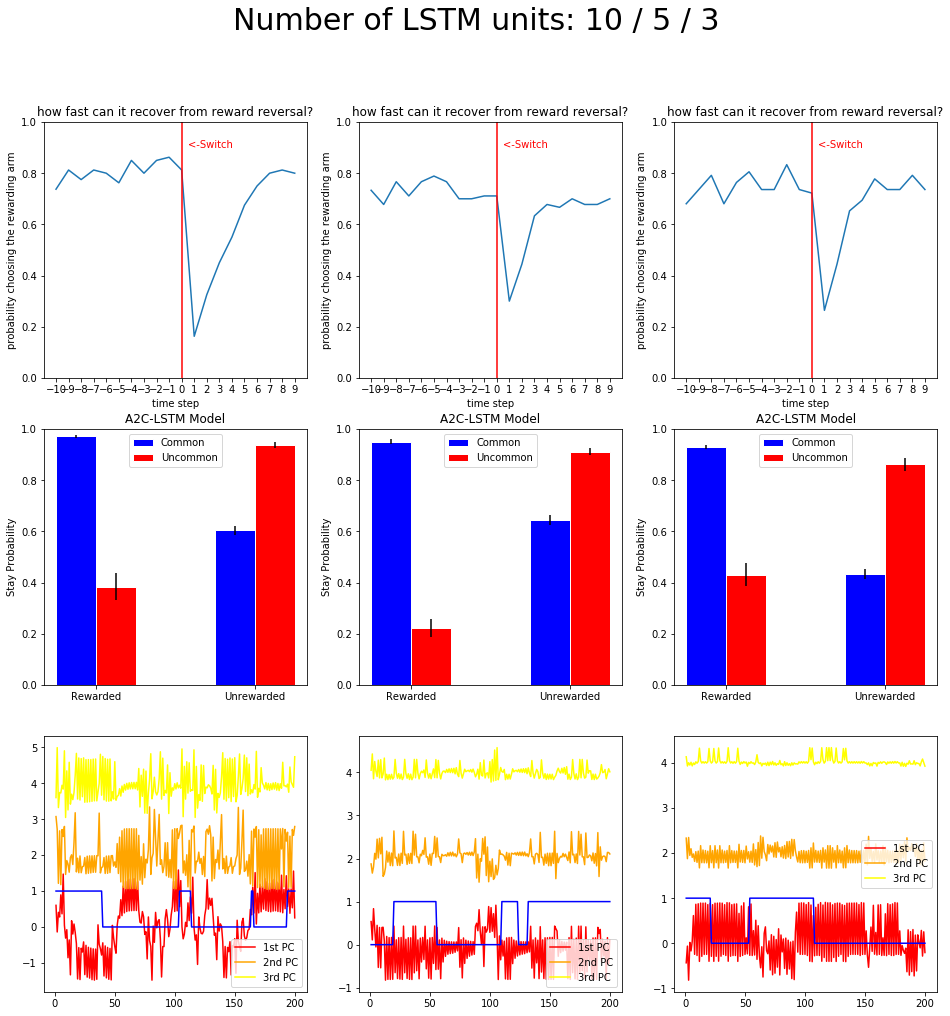

In [30]:
env = TwoStepTask(PSwitch = 0.05, NTrials = 200)
env = make_vec_env(lambda: env, n_envs=1)

#sims = [Simulation('A2C-LSTM10_Standard_PSwitch5e-2/train600000', env = env),
#        Simulation('A2C-LSTM5_Standard_PSwitch5e-2/train600000', env = env),
#        Simulation('A2C-LSTM3_Standard_PSwitch5e-2/train600000', env = env),]

fig, axs = plt.subplots(3, len(sims), figsize = (16, 16))
fig.suptitle('Number of LSTM units: 10 / 5 / 3', fontsize=30)
for ctr, sim in enumerate(sims):
    #sim.evaluate()
    
    # first row: how fast can the model switch behaviors after a switch
    plotActionReversal(axs[0, ctr], sim.TestRollouts)
    
    # second row: MB or MF behavior?
    stayProb, _, _ = calcStayProb(sim.TestRollouts)
    plotStayProb(axs[1, ctr], stayProb)
    
    vis = visualizeH(axs[2, ctr], sim.TestRollouts)
    #cbar = fig.colorbar(vis, ax=axs[2, ctr])
    #cbar.set_label('Trials')
    #cbar.set_ticks(np.arange(0, 1, 0.2))
    #cbar.set_ticklabels(np.arange(0, sim.TestRollouts.NTrials, int(sim.TestRollouts.NTrials / 5)))

In [ ]:
sims = [Simulation('A2C-LSTM10_ActionNoise7e-01_PSwitch5e-2/train25000', env = env)]

results_plotter.plot_results([sims[0].model_path + '/'], 2e6, 'episodes', 'Two-Step Task')


In [15]:
sims[0].TestRollouts.bestArm[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# The below comments are for pytorch implementation
## since stable_baselines provide an easy interface for network testing, we will stick with it for now

In [ ]:
arguments = ' --env-name PongNoFrameskip-v4'
args = my_get_args(arguments)

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

if args.cuda and torch.cuda.is_available() and args.cuda_deterministic:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

log_dir = os.path.expanduser(args.log_dir)
eval_log_dir = log_dir + "_eval"
utils.cleanup_log_dir(log_dir)
utils.cleanup_log_dir(eval_log_dir)

torch.set_num_threads(1)
device = torch.device("cuda:0" if args.cuda else "cpu")



In [ ]:
'''envs = make_vec_envs(args.env_name, args.seed, args.num_processes,
                         args.gamma, args.log_dir, device, False)
'''

In [ ]:
'''
actor_critic = Policy(
        envs.observation_space.shape,
        envs.action_space,
        base_kwargs={'recurrent': args.recurrent_policy})
actor_critic.to(device)

agent = algo.A2C_ACKTR(
            actor_critic,
            args.value_loss_coef,
            args.entropy_coef,
            lr=args.lr,
            eps=args.eps,
            alpha=args.alpha,
            max_grad_norm=args.max_grad_norm)
            '''

In [ ]:
'''
rollouts = RolloutStorage(args.num_steps, args.num_processes,
                              envs.observation_space.shape, envs.action_space,
                              actor_critic.recurrent_hidden_state_size)

obs = envs.reset()
rollouts.obs[0].copy_(obs)
rollouts.to(device)

episode_rewards = deque(maxlen=10)

start = time.time()
num_updates = int(
    args.num_env_steps) // args.num_steps // args.num_processes
    
for j in range(num_updates):

        if args.use_linear_lr_decay:
            # decrease learning rate linearly
            utils.update_linear_schedule(
                agent.optimizer, j, num_updates,
                agent.optimizer.lr if args.algo == "acktr" else args.lr)

        for step in range(args.num_steps):
            # Sample actions
            with torch.no_grad():
                value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                    rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                    rollouts.masks[step])

            # Observe reward and next obs
            obs, reward, done, infos = envs.step(action)

            for info in infos:
                if 'episode' in info.keys():
                    episode_rewards.append(info['episode']['r'])

            # If done then clean the history of observations.
            masks = torch.FloatTensor(
                [[0.0] if done_ else [1.0] for done_ in done])
            bad_masks = torch.FloatTensor(
                [[0.0] if 'bad_transition' in info.keys() else [1.0]
                 for info in infos])
            rollouts.insert(obs, recurrent_hidden_states, action,
                            action_log_prob, value, reward, masks, bad_masks)

        with torch.no_grad():
            next_value = actor_critic.get_value(
                rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                rollouts.masks[-1]).detach()

        if args.gail:
            if j >= 10:
                envs.venv.eval()

            gail_epoch = args.gail_epoch
            if j < 10:
                gail_epoch = 100  # Warm up
            for _ in range(gail_epoch):
                discr.update(gail_train_loader, rollouts,
                             utils.get_vec_normalize(envs)._obfilt)

            for step in range(args.num_steps):
                rollouts.rewards[step] = discr.predict_reward(
                    rollouts.obs[step], rollouts.actions[step], args.gamma,
                    rollouts.masks[step])

        rollouts.compute_returns(next_value, args.use_gae, args.gamma,
                                 args.gae_lambda, args.use_proper_time_limits)

        value_loss, action_loss, dist_entropy = agent.update(rollouts)

        rollouts.after_update()

        # save for every interval-th episode or for the last epoch
        if (j % args.save_interval == 0
                or j == num_updates - 1) and args.save_dir != "":
            save_path = os.path.join(args.save_dir, args.algo)
            try:
                os.makedirs(save_path)
            except OSError:
                pass

            torch.save([
                actor_critic,
                getattr(utils.get_vec_normalize(envs), 'ob_rms', None)
            ], os.path.join(save_path, args.env_name + ".pt"))

        if j % args.log_interval == 0 and len(episode_rewards) > 1:
            total_num_steps = (j + 1) * args.num_processes * args.num_steps
            end = time.time()
            print(
                "Updates {}, num timesteps {}, FPS {} \n Last {} training episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}\n"
                .format(j, total_num_steps,
                        int(total_num_steps / (end - start)),
                        len(episode_rewards), np.mean(episode_rewards),
                        np.median(episode_rewards), np.min(episode_rewards),
                        np.max(episode_rewards), dist_entropy, value_loss,
                        action_loss))

        if (args.eval_interval is not None and len(episode_rewards) > 1
                and j % args.eval_interval == 0):
            ob_rms = utils.get_vec_normalize(envs).ob_rms
            evaluate(actor_critic, ob_rms, args.env_name, args.seed,
                     args.num_processes, eval_log_dir, device)
'''

In [ ]:
num_updates = int(
    args.num_env_steps) // args.num_steps // args.num_processes



In [ ]:
num_updates